In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ff-c23/FaceForensics++_C23/Face2Face/479_706.mp4
/kaggle/input/ff-c23/FaceForensics++_C23/Face2Face/481_469.mp4
/kaggle/input/ff-c23/FaceForensics++_C23/Face2Face/184_205.mp4
/kaggle/input/ff-c23/FaceForensics++_C23/Face2Face/315_322.mp4
/kaggle/input/ff-c23/FaceForensics++_C23/Face2Face/645_688.mp4
/kaggle/input/ff-c23/FaceForensics++_C23/Face2Face/700_813.mp4
/kaggle/input/ff-c23/FaceForensics++_C23/Face2Face/313_283.mp4
/kaggle/input/ff-c23/FaceForensics++_C23/Face2Face/336_338.mp4
/kaggle/input/ff-c23/FaceForensics++_C23/Face2Face/746_571.mp4
/kaggle/input/ff-c23/FaceForensics++_C23/Face2Face/917_924.mp4
/kaggle/input/ff-c23/FaceForensics++_C23/Face2Face/207_908.mp4
/kaggle/input/ff-c23/FaceForensics++_C23/Face2Face/297_270.mp4
/kaggle/input/ff-c23/FaceForensics++_C23/Face2Face/692_610.mp4
/kaggle/input/ff-c23/FaceForensics++_C23/Face2Face/179_212.mp4
/kaggle/input/ff-c23/FaceForensics++_C23/Face2Face/936_931.mp4
/kaggle/input/ff-c23/FaceForensics++_C23/Face2Face/562_

In [2]:
# ================== Cell 1: Configuration and Imports ==================
import os
import numpy as np
import pandas as pd
import cv2
import random
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

2025-06-30 05:35:47.282197: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751261747.466935      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751261747.523711      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
CONFIG = {
    "dataset_path": "/kaggle/input/ff-c23/FaceForensics++_C23",
    "fake_folders": [
        "DeepFakeDetection", "Deepfakes", "Face2Face",
        "FaceShifter", "FaceSwap", "NeuralTextures"
    ],
    "original_folder": "original",
    "input_shape": (128, 128, 3),
    "sequence_length": 10,
    "batch_size": 6,
    "epochs": 12,
    "learning_rate": 1e-4,
    "validation_split": 0.2,
    "test_split": 0.1,
    "num_classes": 1,
    "max_fake_videos_per_folder": 170,
    "model_save_path": "/kaggle/working/deepfake_model.h5",
    "tflite_save_path": "/kaggle/working/model.tflite"
}

In [4]:
# ================== Cell 2: Load Video Paths ==================
base = CONFIG["dataset_path"]
real_folder = os.path.join(base, CONFIG["original_folder"])
real_videos = [os.path.join(real_folder, f) for f in os.listdir(real_folder) if f.endswith(".mp4")][:1000]

fake_videos = []
for folder in CONFIG["fake_folders"]:
    path = os.path.join(base, folder)
    vids = [os.path.join(path, f) for f in os.listdir(path) if f.endswith(".mp4")]
    fake_videos.extend(random.sample(vids, CONFIG["max_fake_videos_per_folder"]))

all_paths = real_videos + fake_videos
all_labels = [0] * len(real_videos) + [1] * len(fake_videos)

X_train_paths, X_test_paths, y_train, y_test = train_test_split(
    all_paths, all_labels, test_size=CONFIG["test_split"], stratify=all_labels, random_state=42
)
X_train_paths, X_val_paths, y_train, y_val = train_test_split(
    X_train_paths, y_train, test_size=CONFIG["validation_split"], stratify=y_train, random_state=42
)


In [5]:
# ================== Cell 3: Frame Extraction ==================
def extract_frames(video_path, num_frames=CONFIG["sequence_length"]):
    cap = cv2.VideoCapture(video_path)
    total = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    interval = max(total // num_frames, 1)
    frames = []
    for i in range(0, total, interval):
        cap.set(cv2.CAP_PROP_POS_FRAMES, i)
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frame = cv2.resize(frame, CONFIG["input_shape"][:2])
        frame = frame.astype("float32") / 255.0
        frames.append(frame)
        if len(frames) == num_frames:
            break
    cap.release()
    while len(frames) < num_frames:
        frames.append(np.zeros(CONFIG["input_shape"], dtype="float32"))
    return np.stack(frames)

In [6]:
# ================== Cell 4: TensorFlow Dataset ==================
def preprocess_video_list(file_paths, labels, augment=False):
    def _load_video(path, label):
        frames = extract_frames(path.numpy().decode())
        if augment:
            frames = tf.image.random_flip_left_right(frames)
        return frames, label

    def _tf_wrapper(path, label):
        frames, lbl = tf.py_function(_load_video, [path, label], [tf.float32, tf.int32])
        frames.set_shape([CONFIG["sequence_length"], *CONFIG["input_shape"]])
        lbl.set_shape([])
        return frames, lbl

    ds = tf.data.Dataset.from_tensor_slices((file_paths, labels))
    ds = ds.shuffle(100).map(_tf_wrapper, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(CONFIG["batch_size"]).prefetch(tf.data.AUTOTUNE)
    return ds

train_ds = preprocess_video_list(X_train_paths, y_train, augment=True)
val_ds = preprocess_video_list(X_val_paths, y_val)
test_ds = preprocess_video_list(X_test_paths, y_test)


I0000 00:00:1751261819.069639      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


In [7]:
# ================== Cell 5: Model ==================
# Load base feature extractor (EfficientNetB0)
base_model = EfficientNetB0(include_top=False, weights="imagenet", pooling="avg", input_shape=CONFIG["input_shape"])
base_model.trainable = True  # fine-tune

# Input: sequence of frames
input_tensor = layers.Input(shape=(CONFIG["sequence_length"], *CONFIG["input_shape"]))  # shape: (None, 20, 128, 128, 3)

# Apply CNN to each frame using TimeDistributed
x = layers.TimeDistributed(base_model)(input_tensor)  # output: (None, 20, 1280)

# Process temporal information
x = layers.LSTM(128, return_sequences=True)(x)  # output: (None, 20, 128)
x = layers.LSTM(64)(x)                           # output: (None, 64)

# Dense layers
x = layers.Dense(64, activation='relu')(x)
x = layers.Dropout(0.5)(x)

# Final binary output
output = layers.Dense(1, activation='sigmoid')(x)

# Build model
model = models.Model(inputs=input_tensor, outputs=output)

# Compile
model.compile(
    optimizer=tf.keras.optimizers.Adam(CONFIG["learning_rate"]),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(name="auc")]
)

# Summary
model.summary()



16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 10, 128, 128, 3)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed (TimeDistributed)   │ (None, 10, 1280)            │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 10, 128)             │         721,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,824,612 (18.40 MB)

 Trainable params: 4,782,589 (18.24 MB)

 Non-trainable params: 42,023 (164.16 KB)

In [8]:
# ================== Cell 6: Training ==================
callbacks = [
    EarlyStopping(monitor="val_auc", patience=5, mode="max", restore_best_weights=True),
    ModelCheckpoint(CONFIG["model_save_path"], monitor="val_auc", save_best_only=True, mode="max"),
    ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, min_lr=1e-7)
]


In [9]:
model.fit(train_ds, validation_data=val_ds, epochs=CONFIG["epochs"], callbacks=callbacks)

Epoch 1/12


E0000 00:00:1751262077.075611      35 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/functional_1/time_distributed_1/block2b_drop_19/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
I0000 00:00:1751262114.456576      98 cuda_dnn.cc:529] Loaded cuDNN version 90300


243/243 ━━━━━━━━━━━━━━━━━━━━ 3770s 14s/step - accuracy: 0.5057 - auc: 0.4953 - loss: 0.6989 - val_accuracy: 0.4615 - val_auc: 0.4785 - val_loss: 0.7005 - learning_rate: 1.0000e-04
Epoch 2/12
243/243 ━━━━━━━━━━━━━━━━━━━━ 3460s 14s/step - accuracy: 0.5518 - auc: 0.5767 - loss: 0.6790 - val_accuracy: 0.5275 - val_auc: 0.5269 - val_loss: 0.6811 - learning_rate: 1.0000e-04
Epoch 3/12
243/243 ━━━━━━━━━━━━━━━━━━━━ 3443s 14s/step - accuracy: 0.6003 - auc: 0.6277 - loss: 0.6461 - val_accuracy: 0.5385 - val_auc: 0.5552 - val_loss: 0.6797 - learning_rate: 1.0000e-04
Epoch 4/12
243/243 ━━━━━━━━━━━━━━━━━━━━ 3467s 14s/step - accuracy: 0.6183 - auc: 0.6394 - loss: 0.6381 - val_accuracy: 0.4176 - val_auc: 0.4464 - val_loss: 0.8042 - learning_rate: 1.0000e-04
Epoch 5/12
243/243 ━━━━━━━━━━━━━━━━━━━━ 3434s 14s/step - accuracy: 0.6037 - auc: 0.6424 - loss: 0.6340 - val_accuracy: 0.5000 - val_auc: 0.5123 - val_loss: 0.7075 - learning_rate: 1.0000e-04
Epoch 6/12
243/243 ━━━━━━━━━━━━━━━━━━━━ 3439s 14s/step -

In [10]:
model.save("/kaggle/working/full_deepfake_model.h5")




34/34 ━━━━━━━━━━━━━━━━━━━━ 445s 11s/step


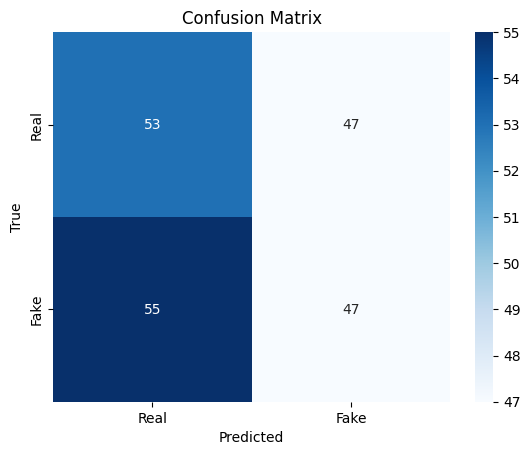


Classification Report:
              precision    recall  f1-score   support

        Real       0.49      0.53      0.51       100
        Fake       0.50      0.46      0.48       102

    accuracy                           0.50       202
   macro avg       0.50      0.50      0.49       202
weighted avg       0.50      0.50      0.49       202



In [11]:
# ================== Cell 7: Evaluation ==================
y_prob = model.predict(test_ds).flatten()
y_pred = (y_prob > 0.5).astype(int)
y_true = np.concatenate([y for _, y in test_ds], axis=0)

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Real", "Fake"], yticklabels=["Real", "Fake"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=["Real", "Fake"]))